# Project 3

In this project, you will perform a logistic regression on the admissions data we've been working with in projects 1 and 2.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import statsmodels.api as sm
import pylab as pl
import numpy as np


/Users/cour7816/anaconda2/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [2]:
df_raw = pd.read_csv("../assets/admissions.csv")
df = df_raw.dropna() 
print df.head()

   admit    gre   gpa  prestige
0      0  380.0  3.61       3.0
1      1  660.0  3.67       3.0
2      1  800.0  4.00       1.0
3      1  640.0  3.19       4.0
4      0  520.0  2.93       4.0


## Part 1. Frequency Tables

#### 1. Let's create a frequency table of our variables

In [3]:
# frequency table for prestige and whether or not someone was admitted
print 'Admit Frequency'
print df['admit'].value_counts()

print 'Prestige Frequency'
print df['prestige'].value_counts()

Admit Frequency
0    271
1    126
Name: admit, dtype: int64
Prestige Frequency
2.0    148
3.0    121
4.0     67
1.0     61
Name: prestige, dtype: int64


In [4]:
pd.crosstab(index=df['prestige'],columns="count")

col_0,count
prestige,
1.0,61
2.0,148
3.0,121
4.0,67


In [5]:
pd.crosstab(index=df['admit'], columns="count")

col_0,count
admit,
0,271
1,126


## Part 2. Return of dummy variables

#### 2.1 Create class or dummy variables for prestige 

In [6]:
dummy_ranks = pd.get_dummies(df.prestige, prefix='prestige')

#### 2.2 When modeling our class variables, how many do we need? 



We need three variables - one fewer than the number of unique rank values.

## Part 3. Hand calculating odds ratios

Develop your intuition about expected outcomes by hand calculating odds ratios.

In [7]:
cols_to_keep = ['admit', 'gre', 'gpa']
handCalc = df[cols_to_keep].join(dummy_ranks.ix[:, 'prestige_1.0':])
print handCalc.head()

   admit    gre   gpa  prestige_1.0  prestige_2.0  prestige_3.0  prestige_4.0
0      0  380.0  3.61           0.0           0.0           1.0           0.0
1      1  660.0  3.67           0.0           0.0           1.0           0.0
2      1  800.0  4.00           1.0           0.0           0.0           0.0
3      1  640.0  3.19           0.0           0.0           0.0           1.0
4      0  520.0  2.93           0.0           0.0           0.0           1.0


In [13]:
#crosstab prestige 1 admission 
# frequency table cutting prestige and whether or not someone was admitted
admitted = pd.crosstab(index=df["admit"], columns=df["prestige"], margins=True)

admitted.columns = ['prestige_1.0', 'prestige_2.0', 'prestige_3.0', 'prestige_4.0', 'All']
admitted.index = ['0', '1', 'All']

admitted

,prestige_1.0,prestige_2.0,prestige_3.0,prestige_4.0,All
0,28,95,93,55,271
1,33,53,28,12,126
All,61,148,121,67,397


In [15]:
print pd.crosstab(df['admit'], df['prestige'], margins=True)

prestige  1.0  2.0  3.0  4.0  All
admit                            
0          28   95   93   55  271
1          33   53   28   12  126
All        61  148  121   67  397


#### 3.1 Use the cross tab above to calculate the odds of being admitted to grad school if you attended a #1 ranked college

In [16]:
# odds of being admitted to grad school
# odds = p/1-p
p = float(33)/(61)

p1odds = float(p/(1-p))
p1odds

1.1785714285714288

#### 3.2 Now calculate the odds of admission if you did not attend a #1 ranked college

In [17]:
# sum of admitted 
53+28+12

93

In [18]:
# sum of total applied
95+93+55+93

336

In [20]:
p2 = float(93)/(336)

p2odds = float(p2/(1-p2))
p2odds

0.3827160493827161

#### 3.3 Calculate the odds ratio

In [21]:
odds_ratio = float(p1odds/p2odds)
odds_ratio

3.079493087557604

#### 3.4 Write this finding in a sentenance: 

A student that attended a #1 prestige school is 308% more likely to be admitted than a student that did not.

#### 3.5 Print the cross tab for prestige_4

In [22]:
pd.crosstab(handCalc['admit'], handCalc['prestige_4.0'], margins=True)


prestige_4.0,0.0,1.0,All
admit,,,
0,216,55,271
1,114,12,126
All,330,67,397


#### 3.6 Calculate the OR 

In [23]:
p41=float(12)/(67)
p41odds = float(p41/(1-p41))


p40=float(115)/(330)
p40odds = float(p40/(1-p40))


odds_ratiop4 = float(p41odds/p40odds)
odds_ratiop4

0.40790513833992087

#### 3.7 Write this finding in a sentence

Answer: If a student has a prestige ranking of 4, they are 41% less likely to get admitted than if they had a prestige ranking of 1, 2, or 3. 

## Part 4. Analysis

In [24]:
# create a clean data frame for the regression
cols_to_keep = ['admit', 'gre', 'gpa']
data = df[cols_to_keep].join(dummy_ranks.ix[:, 'prestige_2':])
print data.head()

   admit    gre   gpa  prestige_2.0  prestige_3.0  prestige_4.0
0      0  380.0  3.61           0.0           1.0           0.0
1      1  660.0  3.67           0.0           1.0           0.0
2      1  800.0  4.00           0.0           0.0           0.0
3      1  640.0  3.19           0.0           0.0           1.0
4      0  520.0  2.93           0.0           0.0           1.0


We're going to add a constant term for our Logistic Regression. The statsmodels function we're going to be using requires that intercepts/constants are specified explicitly.

In [25]:
# manually add the intercept
data['intercept'] = 1.0

#### 4.1 Set the covariates to a variable called train_cols

In [26]:
train_cols = data.columns[1:]

#### 4.2 Fit the model

In [27]:
model = sm.Logit(data['admit'], data[train_cols])

#### 4.3 Print the summary results

In [28]:
result = model.fit()

result.summary()

Optimization terminated successfully.
         Current function value: 0.573854
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                  admit   No. Observations:                  397
Model:                          Logit   Df Residuals:                      391
Method:                           MLE   Df Model:                            5
Date:                Mon, 30 Jan 2017   Pseudo R-squ.:                 0.08166
Time:                        17:18:08   Log-Likelihood:                -227.82
converged:                       True   LL-Null:                       -248.08
                                        LLR p-value:                 1.176e-07
================================================================================
                   coef    std err          z      P>|z|      [95.0% Conf. Int.]
--------------------------------------------------------------------------------
gre              0.0022      0.001      2.028      0.043      7.44e-05     0.004
gpa              0.7793      0.333      2.344      0.019         0.128     1.431
prestige_2.0    -0.6801      0.317     -2.146      0.032        -1.301    -0.059
prestige_3.0    -1.3387      0.345     -3.882      0.000        -2.015    -0.663
prestige_4.0    -1.5534      0.417     -3.721      0.000        -2.372    -0.735
intercept       -3.8769      1.142     -3.393      0.001        -6.116    -1.638
================================================================================
"""

#### 4.4 Calculate the odds ratios of the coeffiencents and their 95% CI intervals



In [29]:
print np.exp(result.params)

gre             1.002221
gpa             2.180027
prestige_2.0    0.506548
prestige_3.0    0.262192
prestige_4.0    0.211525
intercept       0.020716
dtype: float64


In [30]:
params = result.params
conf = result.conf_int()
conf['OR'] = params
conf.columns = ['2.5%', '97.5%', 'OR']
print np.exp(conf)

                  2.5%     97.5%        OR
gre           1.000074  1.004372  1.002221
gpa           1.136120  4.183113  2.180027
prestige_2.0  0.272168  0.942767  0.506548
prestige_3.0  0.133377  0.515419  0.262192
prestige_4.0  0.093329  0.479411  0.211525
intercept     0.002207  0.194440  0.020716


#### 4.5 Interpret the OR of Prestige_2

Answer: If the prestige of a school is two, the odds of being admitted decreases by 50.65%. 

#### 4.6 Interpret the OR of GPA

Answer: If GPA increases by 1 unit, the odds of being admitted increases by 218%. 

## Part 5: Predicted probablities


As a way of evaluating our classifier, we're going to recreate the dataset with every logical combination of input values. This will allow us to see how the predicted probability of admission increases/decreases across different variables. First we're going to generate the combinations using a helper function called cartesian (above).

We're going to use np.linspace to create a range of values for "gre" and "gpa". This creates a range of linearly spaced values from a specified min and maximum value--in our case just the min/max observed values.

In [32]:
def cartesian(arrays, out=None):
    """
    Generate a cartesian product of input arrays.
    Parameters
    ----------
    arrays : list of array-like
        1-D arrays to form the cartesian product of.
    out : ndarray
        Array to place the cartesian product in.
    Returns
    -------
    out : ndarray
        2-D array of shape (M, len(arrays)) containing cartesian products
        formed of input arrays.
    Examples
    --------
    >>> cartesian(([1, 2, 3], [4, 5], [6, 7]))
    array([[1, 4, 6],
           [1, 4, 7],
           [1, 5, 6],
           [1, 5, 7],
           [2, 4, 6],
           [2, 4, 7],
           [2, 5, 6],
           [2, 5, 7],
           [3, 4, 6],
           [3, 4, 7],
           [3, 5, 6],
           [3, 5, 7]])
    """

    arrays = [np.asarray(x) for x in arrays]
    dtype = arrays[0].dtype

    n = np.prod([x.size for x in arrays])
    if out is None:
        out = np.zeros([n, len(arrays)], dtype=dtype)

    m = n / arrays[0].size
    out[:,0] = np.repeat(arrays[0], m)
    if arrays[1:]:
        cartesian(arrays[1:], out=out[0:m,1:])
        for j in xrange(1, arrays[0].size):
            out[j*m:(j+1)*m,1:] = out[0:m,1:]
    return out

In [33]:
# instead of generating all possible values of GRE and GPA, we're going
# to use an evenly spaced range of 10 values from the min to the max 
gres = np.linspace(data['gre'].min(), data['gre'].max(), 10)
print gres
# array([ 220.        ,  284.44444444,  348.88888889,  413.33333333,
#         477.77777778,  542.22222222,  606.66666667,  671.11111111,
#         735.55555556,  800.        ])
gpas = np.linspace(data['gpa'].min(), data['gpa'].max(), 10)
print gpas
# array([ 2.26      ,  2.45333333,  2.64666667,  2.84      ,  3.03333333,
#         3.22666667,  3.42      ,  3.61333333,  3.80666667,  4.        ])


# enumerate all possibilities
combos = pd.DataFrame(cartesian([gres, gpas, [1, 2, 3, 4], [1.]]))

[ 220.          284.44444444  348.88888889  413.33333333  477.77777778
  542.22222222  606.66666667  671.11111111  735.55555556  800.        ]
[ 2.26        2.45333333  2.64666667  2.84        3.03333333  3.22666667
  3.42        3.61333333  3.80666667  4.        ]


In [34]:
combos.head()

,0,1,2,3
0,220.0,2.260000,1.0,1.0
1,220.0,2.260000,2.0,1.0
2,220.0,2.260000,3.0,1.0
3,220.0,2.260000,4.0,1.0
4,220.0,2.453333,1.0,1.0


In [35]:
combos.columns = ['gre', 'gpa', 'prestige', 'intercept']
combos.head()

,gre,gpa,prestige,intercept
0,220.0,2.260000,1.0,1.0
1,220.0,2.260000,2.0,1.0
2,220.0,2.260000,3.0,1.0
3,220.0,2.260000,4.0,1.0
4,220.0,2.453333,1.0,1.0


#### 5.1 Recreate the dummy variables

In [36]:
# recreate the dummy variables
dummy_ranks = pd.get_dummies(combos['prestige'], prefix='prestige')

# keep only what we need for making predictions
keep_cols = ['gre', 'gpa', 'intercept', 'prestige']
combos = combos[keep_cols].join(dummy_ranks.ix[:, 'prestige_2':])
combos.head()

,gre,gpa,intercept,prestige,prestige_2.0,prestige_3.0,prestige_4.0
0,220.0,2.260000,1.0,1.0,0.0,0.0,0.0
1,220.0,2.260000,1.0,2.0,1.0,0.0,0.0
2,220.0,2.260000,1.0,3.0,0.0,1.0,0.0
3,220.0,2.260000,1.0,4.0,0.0,0.0,1.0
4,220.0,2.453333,1.0,1.0,0.0,0.0,0.0


#### 5.2 Make predictions on the enumerated dataset

In [37]:
combos['admit_pred'] = result.predict(combos[train_cols])
combos.tail()

,gre,gpa,intercept,prestige,prestige_2.0,prestige_3.0,prestige_4.0,admit_pred
395,800.0,3.806667,1.0,4.0,0.0,0.0,1.0,0.334286
396,800.0,4.000000,1.0,1.0,0.0,0.0,0.0,0.734040
397,800.0,4.000000,1.0,2.0,1.0,0.0,0.0,0.582995
398,800.0,4.000000,1.0,3.0,0.0,1.0,0.0,0.419833
399,800.0,4.000000,1.0,4.0,0.0,0.0,1.0,0.368608


#### 5.3 Interpret findings for the last 4 observations

Student #396, with a GRE of 800, GPA of 4.0, and a school rank of 1, has a 73% chance of being admitted. 

Student #397, with a GRE of 800, GPA of 4.0, and a school rank of 2, has a 58% chance of being admitted. 

Student #398, with a GRE of 800, GPA of 4.0, and a school rank of  3, has a 42% chance of being admitted. 

Student #399, with a GRE of 800, GPA of 4.0, and a school rank of 4, has  a 37% chance of being admitted. 

## Bonus

Plot the probability of being admitted into graduate school, stratified by GPA and GRE score.

In [46]:
features = [i for i in combos.columns if 'prestige' in i]

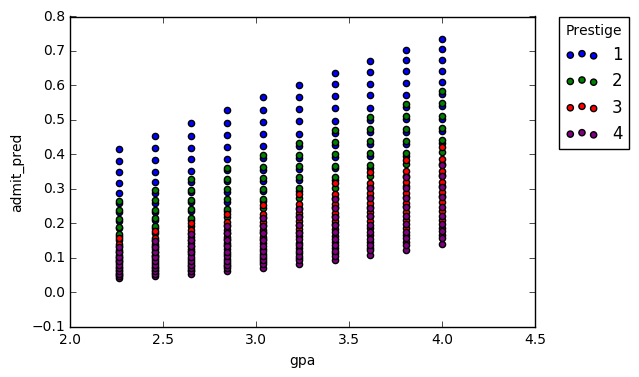

In [54]:
%matplotlib inline
ax = plt.subplot(111)
colors = ['blue', 'green', 'red', 'purple']
for e, c in enumerate(colors):
    combos[combos[features[e]] == 1].plot(x='gpa', y='admit_pred', kind='scatter', color=c, ax=ax, label=features[e])
    
plt.legend(['1','2','3','4'], title='Prestige', bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0)

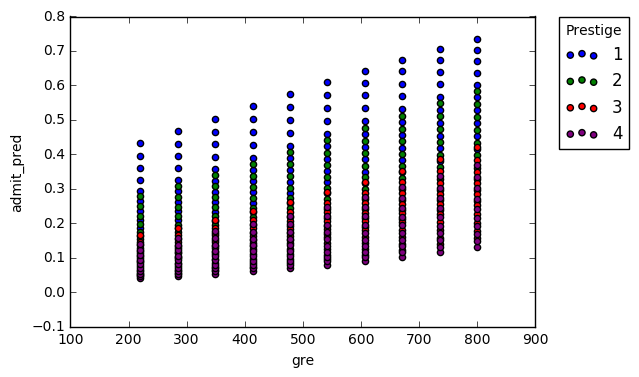

In [55]:
ax = plt.subplot(111)
colors = ['blue', 'green', 'red', 'purple']
for e, c in enumerate(colors):
    combos[combos[features[e]] == 1].plot(x='gre', y='admit_pred', kind='scatter', color=c, ax=ax, label=features[e])
    
plt.legend(['1','2','3','4'], title='Prestige', bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0)